# Heatmap classifier model

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [2]:
import pickle

class HeatmapDataset(Dataset):
    """My dataset."""

    def __init__(self, pickle_path, transform=None, n_sample=None):
        super(HeatmapDataset, self).__init__()
        self.pickle_path = pickle_path
        self.transform = transform
        
        # load
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
            self.boxes_data = torch.tensor(data['boxes'])
            self.heatmap_data = torch.tensor(data['heatmaps'])
            self.targets = torch.tensor(data['targets'])
            
        # n개만 샘플링 - validation용
        if(n_sample is not None):
            sample_indices = np.random.choice(len(self.heatmap_data), n_sample, replace=False)
            self.boxes_data = self.boxes_data[sample_indices]
            self.heatmap_data = self.heatmap_data[sample_indices]
            self.targets = self.targets[sample_indices]

        self.n_classes = self.targets.max().item() + 1
        assert len(self.heatmap_data)==len(self.boxes_data), "num_heatmap != num_box"

    def __len__(self):
        return len(self.heatmap_data)

    def __getitem__(self, idx):
        heatmap = self.heatmap_data[idx]
        bboxes = self.boxes_data[idx]
        targets = self.targets[idx]
        
        if self.transform:
            heatmap = self.transform(heatmap).unsqueeze(0)

        one_hot = torch.zeros(self.n_classes)
        one_hot[targets.squeeze().long()] = 1
        #  현재 프레임당 bbox 1개씩 뿐이라 sqaueeze힌것. 여러개땐 차원 고려해야함
        return heatmap.float(), bboxes.squeeze().float(), one_hot

# def myCollate(batch):
#     img_list = []
#     box_list = []
#     for img, box in batch:
#         img_list.append(img)
#         box_list.append(box)
#     return torch.stack(img_list), torch.stack(box_list)

In [3]:
pickle_path = 'heatmap_composed.pickle'
pickle_val_path = 'heatmap_composed_val.pickle'

my_dataset = HeatmapDataset(pickle_path)
my_dataset_val = HeatmapDataset(pickle_val_path, n_sample=100)


my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=4, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)
my_loader_val = torch.utils.data.DataLoader(my_dataset_val, batch_size=4, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)


dataloaders = {
    'train': my_loader,
    'val': my_loader_val
}
dataset_sizes = {
    'train': len(my_dataset),
    'val': len(my_dataset_val)
}
# i,b = next(iter(my_loader))
# i.shape, b.shape

print(dataset_sizes)

{'train': 1599, 'val': 100}


In [43]:
my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=2, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)

loader = iter(my_loader_test)

def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

In [44]:
heatmap, box, target= loader.next()
box = box.cpu().numpy() 
# box = cvt_yolobox(box, heatmap.shape[-2:])

In [45]:
target, box

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0.498437, 0.567361, 0.321875, 0.293056],
        [0.607031, 0.518056, 0.54375 , 0.341667]], dtype=float32))

In [51]:
[i.shape for i in [heatmap, box, target]]

[torch.Size([2, 31, 224, 224]), (2, 4), torch.Size([2, 1])]

In [5]:
multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)
# attn_output, attn_output_weights = multihead_attn(query, key, value)

In [31]:
hh = model.backbone(heatmap.transpose(0,1).reshape(-1,1,224,224).cuda().float()) # 62,512 
hh = hh.reshape(-1, 2, 512) # 31,2,512
hh.shape

torch.Size([31, 2, 512])

In [32]:
multihead_attn.to('cuda')
attn_output, attn_output_weights = multihead_attn(hh, hh, hh) # q,k,v - L,N,E - 31,8,512

In [33]:
attn_output.shape, attn_output_weights.shape, target.squeeze(1)

(torch.Size([31, 2, 512]),
 torch.Size([2, 31, 31]),
 tensor([8, 5], dtype=torch.int32))

In [38]:
res = attn_output.transpose(0,1)
res.shape

torch.Size([2, 31, 512])

In [39]:
res2 = res.reshape(-1,512)
res2.shape

torch.Size([62, 512])

In [49]:
linear = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
linear.to('cuda')

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [52]:
pp = linear(res2)
pp = pp.reshape(2,-1)
pp.shape

torch.Size([2, 31])

In [55]:
nn.Sigmoid()(pp), nn.Softmax(pp)

(tensor([[0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100,
          0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100,
          0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100, 0.5100,
          0.5100, 0.5100, 0.5100, 0.5100],
         [0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101,
          0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101,
          0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101, 0.5101,
          0.5101, 0.5101, 0.5101, 0.5101]], device='cuda:0',
        grad_fn=<SigmoidBackward>), Softmax(
   dim=tensor([[0.0400, 0.0400, 0.0400, 0.0400, 0.0399, 0.0399, 0.0400, 0.0400, 0.0399,
            0.0399, 0.0400, 0.0400, 0.0400, 0.0399, 0.0400, 0.0400, 0.0399, 0.0399,
            0.0399, 0.0400, 0.0400, 0.0399, 0.0399, 0.0399, 0.0400, 0.0399, 0.0400,
            0.0400, 0.0400, 0.0399, 0.0399],
           [0.0405, 0.0405, 0.0405, 0.0405, 0.0405, 0.0405

In [15]:
heatmap[0][0].float().sigmoid()

tensor([[0.5931, 0.5938, 0.5944,  ..., 0.6030, 0.6030, 0.6031],
        [0.5936, 0.5943, 0.5948,  ..., 0.6037, 0.6038, 0.6038],
        [0.5941, 0.5947, 0.5953,  ..., 0.6045, 0.6045, 0.6046],
        ...,
        [0.6257, 0.6257, 0.6257,  ..., 0.6256, 0.6252, 0.6248],
        [0.6256, 0.6256, 0.6256,  ..., 0.6253, 0.6249, 0.6245],
        [0.6253, 0.6253, 0.6253,  ..., 0.6251, 0.6246, 0.6243]])

In [24]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1)),#, dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1)),#, dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 256, kernel_size=(3,3), stride=(1, 1)),#, dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 512 x 24 x 24
            avg_pool, # n x 512 x 1 x 1
            flatten, # n x 512
        )
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)

                
        # fc layer
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, inputs):
        """
        inputs - 2,31,224,224
        """
        n_batch = inputs.shape[0] # 2
        # CNN backbone
        images = inputs.transpose(0,1).reshape(-1,1,224,224) # 62,1,224,224
        hh = self.backbone(images) # 62,512 
        hh = hh.reshape(-1, n_batch, 512) # 31,2,512
        
        attn_output, attn_output_weights = self.multihead_attn(hh, hh, hh) # q,k,v - L,N,E - 31,2,512        

        res = attn_output.transpose(0,1) # 2,31,512

        res2 = res.reshape(-1,512) # 62,512
        
        pp = self.fc(res2) # 62,1
        logit = pp.reshape(n_batch,-1) # 2,31
#         logit = pp.squeeze() # 2,31
        
        return logit


In [25]:
from torchsummary import summary
model = BoxMaker()
model.to(model.device)
summary(model, (4, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             320
       BatchNorm2d-2         [-1, 32, 222, 222]              64
              ReLU-3         [-1, 32, 222, 222]               0
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]          18,496
       BatchNorm2d-6         [-1, 64, 109, 109]             128
              ReLU-7         [-1, 64, 109, 109]               0
         MaxPool2d-8           [-1, 64, 54, 54]               0
            Conv2d-9          [-1, 256, 52, 52]         147,712
      BatchNorm2d-10          [-1, 256, 52, 52]             512
             ReLU-11          [-1, 256, 52, 52]               0
        MaxPool2d-12          [-1, 256, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [26]:
from torch.optim import lr_scheduler
import time 
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    global loss_list_train, loss_list_val
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, boxes_gt, targets) in enumerate(dataloaders[phase]):
                inputs = inputs.to(model.device)
#                 boxes_gt = boxes_gt.to(model.device) # shape맞춰야함
                targets = targets.to(model.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
#                     boxes_pred = model(inputs)
                    logits = model(inputs)
                    loss = criterion(logits, targets)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                _, preds = torch.max(logits, 1)
                __, target_labels = torch.max(targets, 1)
                running_corrects += sum(preds == target_labels).item()
                
                # mini batch statistics
                if idx>0 and idx%50==0 and phase=='train':
                    cnt = idx*dataloaders[phase].batch_size
                    print('[batch]{}, {} Loss: {:.4f}, Acc: {:.4f}'.format(cnt, phase, running_loss/cnt, running_corrects/cnt))
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if(phase=='train'): loss_list_train.append(epoch_loss)
            else: loss_list_val.append(epoch_loss)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
# model.load_state_dict(torch.load('torch_models/heatmap.pth'))

In [28]:
# def criterion(box_pred, box_gt):
#     """
#     box - N x 4, cx,cy,w,h (normalized like Yolo data)
#     """
#     loss = (box_pred-box_gt).pow(2)
#     loss2 = loss[:,:2]*500 + loss[:, 2:]
#     return loss2.sum()

In [29]:
criterion = nn.BCEWithLogitsLoss(reduction='sum')

loss_list_train = []
loss_list_val = []
# Observe that only parameters of final layer are being optimized as
# optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [30]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
[batch]200, train Loss: 5.4571, Acc: 0.1550
[batch]400, train Loss: 4.5351, Acc: 0.3475
[batch]600, train Loss: 3.9590, Acc: 0.4483
[batch]800, train Loss: 3.5727, Acc: 0.5062
[batch]1000, train Loss: 3.4059, Acc: 0.5320
[batch]1200, train Loss: 3.2462, Acc: 0.5525
[batch]1400, train Loss: 3.0998, Acc: 0.5729
train Loss: 3.0096, Acc: 0.5779
val Loss: 2.7667, Acc: 0.6900
Epoch 1/99
----------
[batch]200, train Loss: 2.5694, Acc: 0.6600
[batch]400, train Loss: 2.3937, Acc: 0.6575
[batch]600, train Loss: 2.3822, Acc: 0.6683
[batch]800, train Loss: 2.3580, Acc: 0.6650
[batch]1000, train Loss: 2.3096, Acc: 0.6730
[batch]1200, train Loss: 2.3132, Acc: 0.6675
[batch]1400, train Loss: 2.3081, Acc: 0.6693
train Loss: 2.3192, Acc: 0.6617
val Loss: 8.0376, Acc: 0.5900
Epoch 2/99
----------
[batch]200, train Loss: 2.1496, Acc: 0.7050
[batch]400, train Loss: 2.3175, Acc: 0.6675
[batch]600, train Loss: 2.2572, Acc: 0.6817
[batch]800, train Loss: 2.2387, Acc: 0.6813
[batch]1000,

KeyboardInterrupt: 

In [ ]:
2.5~2.8

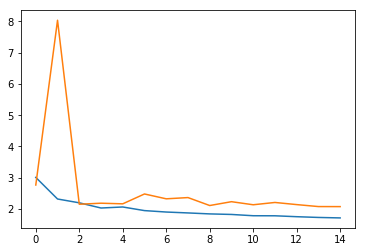

In [31]:
plt.plot(loss_list_train)
plt.plot(loss_list_val)
plt.show()

In [32]:
model.eval()
torch.save(model.state_dict(), 'torch_models/heatmap-cls.pth')

---
# Test

In [15]:
import matplotlib.patches as patches

my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=8, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)

loader = iter(my_loader_test)
model.eval()

def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

[ 34  37 104 172]


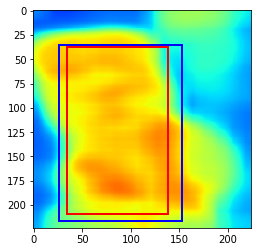

In [332]:
heatmap, box = loader.next()
box = box.cpu().numpy() 
box = cvt_yolobox(box.squeeze(1), heatmap.shape[-2:])
# x1,y1,w1,h1 = box[0]
# box_adj = model(heatmap.cuda()).detach().cpu().numpy()
# box_adj = cvt_yolobox(box_adj, heatmap.shape[-2:])
# x2,y2,w2,h2 = box_adj[0]
# print(box_adj[0])

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
imgplot = ax.imshow(heatmap[0][0].cpu(), cmap='jet')
imgplot.set_clim(0,1)

# Create a Rectangle patch
rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
rect_pred = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect_pred)

plt.show()